# Documentatie proiect - Inteligenta Artificiala
## Moisii Lucian - Grupa 241

## 1. Tema proiectului
In acest proiect ne dorim sa cream un algoritm de invatare automata care este capabil sa clasifice imagini cu tomografii asupra creierului in doua categorii: persoane care nu prezinta nimic suspicios, categorie pe care o vom denumi drept cea **normala**, iar cea de-a doua va fi cea in care tomografiile prezinta **anomalii**.
Link competitie: https://www.kaggle.com/competitions/unibuc-brain-ad/data

## 2. Procesarea datelor
Setul nostru de date contine:
* 15000 imagini pentru antrenare
* 2000 de imagini pentru validare
* 5149 de imagini pentru testare
Clasele vor fi denumite astfel:
* 0 - tomografii normale
* 1 - tomografii ce prezinta anomalii

Toate imaginile oferite sunt 224x224 pixeli, in format Grayscale.

In cadrul acestui proiect vom folosi mai multe modele, iar in urma testarii fiecaruia vom continua prin ajustarea hiperparametrilor celui mai performant model.

Pentru diferite modele vom folosi diferite metode de a citi datele pentru a face algoritmul cat mai eficient din punctul de vedere al antrenarii si a memoriei RAM/VRAM folosite.

De asemenea, pentru a putea masura cat mai corect predictia algoritmilor, vom folosi o alta metrica: f1_score care este definita drept f1_score = 2 * (precision * recall) / (precision + recall). Asadar, in continuare, prin "scor" ne vom referi la f1_score.

## 3.1 Arbore de decizie

Un Decision Tree este un model de algoritm de invatare automata supravegheata care creeaza un arbore in care fiecare nod reprezinta o decizie, iar prin parcurgerea acestuia putem face o predictie asupra datelor. Datele noastre de intrare vor fi reprezentate de valorile fiecarui pixel din imagine, valoare din intervalul [0, 255].


## 3.1.1 Preprocesarea si incarcarea datelor

Pentru a putea antrena modelul avem nevoie sa incarcam datele in program si sa le normalizam. Pentru acest lucru am implementat urmatoarea clasa, in care vom adauga si metoda prin care vom obtine datele:

In [3]:
import numpy as np
import os
import cv2
from sklearn import preprocessing
import pandas as pd

class Data:
    def __init__(self, imagesPath=None, trainLabelsPath=None, testLabelsPath=None) -> None:
        self.imagesPath = imagesPath
        self.trainLabelsPath = trainLabelsPath
        self.testLabelsPath = testLabelsPath
        self.trainImages = None
        self.trainLabels = None
        self.validationImages = None
        self.validationLabels = None
        self.testImages = None
        self.outFile = None
        self.predicted_image_index = 17001
            
    def LoadData(self):
        filenames = os.listdir(self.imagesPath)
        trainImages = []
        for file in filenames:
            data = cv2.imread(self.imagesPath + file, cv2.IMREAD_GRAYSCALE)
            trainImages.append(data.flatten())
        
        columnTypes = {'id': str, 'class':int}
        
        dataframe = pd.read_csv(self.trainLabelsPath, dtype=columnTypes)
        trainLabels = dataframe['class'].values
        
        
        dataframe = pd.read_csv(self.testLabelsPath, dtype=columnTypes)
        validationLabels = dataframe['class'].values

        validationImages = trainImages[len(trainLabels):len(trainLabels) + len(validationLabels)]
        testImages = trainImages[len(trainLabels) + len(validationLabels):]
        trainImages = trainImages[:len(trainLabels)]

        return (trainImages, trainLabels, validationImages, validationLabels, testImages)
    
    
    def NormalizeData(self, trainImages, testImages, submitData, type=None):
        scaler = None
        if type == 'standard':
            scaler = preprocessing.StandardScaler()
        elif type == 'min_max':
            scaler = preprocessing.MinMaxScaler()
        elif type == 'l1':
            scaler = preprocessing.Normalizer(norm='l1')
        elif type == 'l2':
            scaler = preprocessing.Normalizer(norm='l2')
        if scaler is not None:
            scaler.fit(trainImages)
            trainImages = scaler.transform(trainImages)
            testImages = scaler.transform(testImages)
            submitData = scaler.transform(submitData) 
        return (trainImages, testImages, submitData)
    
    def OpenFolder(self):
        outFile = open('submissions.csv', 'w')
        outFile.write('id,class\n')
        
    def CloseFolder(self):
        outFile.close()
    
    def PrintData(self, predicted_values):
        for x in predicted_values:
            outFile.write(f'{self.predicted_image_index:06d},{int(x)}\n')
            self.predicted_image_index += 1

## 3.1.2 Testarea modelului
Vom testa mai multe normalizari si mai multe adancimi ale arborelui, iar pentru a face acest proces mai rapid vom utiliza thread-uri.
Acum putem antrena modelul, iar pentru asta vom folosi libraria scikit-learn:

In [18]:
from sklearn import tree
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, wait

threadPool = ThreadPoolExecutor(max_workers=2)
normalized_train_data = None
train_labels = None
normalized_validation_data = None
validation_labels = None
normalized_test_data = None
giniDecisionTree = None
entropyDecisionTree = None
imagesPath = 'data/data/'
trainLabelsPath = 'data/train_labels.txt'
validationLabelsPath = 'data/validation_labels.txt'

def TrainDecisionTree(criterion):
    global giniDecisionTree, entropyDecisionTree, normalized_train_data, train_labels
    if criterion == 'gini':
        giniDecisionTree = tree.DecisionTreeClassifier(criterion='gini')
        giniDecisionTree.fit(normalized_train_data, train_labels)
    else:
        entropyDecisionTree = tree.DecisionTreeClassifier(criterion='entropy')
        entropyDecisionTree.fit(normalized_train_data, train_labels)
    

def BenchmarkDecisionTree(normalization):
    global normalized_validation_data, validation_labels, threadPool
    futures = [
        threadPool.submit(TrainDecisionTree, 'gini'),
        threadPool.submit(TrainDecisionTree, 'entropy'),
    ]
    wait(futures)
        
    return f1_score(validation_labels, giniDecisionTree.predict(normalized_validation_data)), f1_score(validation_labels, entropyDecisionTree.predict(normalized_validation_data))

if __name__ == '__main__':
    normalizations = ['l2', 'l1', 'min_max', 'standard']
    futures = []
    data_loader = Data(imagesPath, trainLabelsPath, validationLabelsPath)
    train_data, train_labels, validation_data, validation_labels, test_data = data_loader.LoadData()
    for normalization in normalizations:
        normalized_train_data, normalized_validation_data, normalized_test_data = data_loader.NormalizeData(train_data,
                                                                                                            validation_data,
                                                                                                            test_data,
                                                                                                            type=normalization)
        x, y = BenchmarkDecisionTree(normalization)
        print(f'Decision Tree f1_scores with normalization {normalization}: gini - {x:.4f}  entropy - {y:.4f}')

Decision Tree f1_scores with normalization l2: gini - 0.3481  entropy - 0.3304
Decision Tree f1_scores with normalization l1: gini - 0.3172  entropy - 0.3077
Decision Tree f1_scores with normalization min_max: gini - 0.3850  entropy - 0.3293
Decision Tree f1_scores with normalization standard: gini - 0.3875  entropy - 0.3362


## 3.1.3 Tunarea hyperparametrilor
In primul rand trebuie sa abordam faptul ca incercam sa clasificam doua clase disproportionate si anume ca anomaliie sunt mult mai rare, astfel ar trebui sa penalizam algoritmul si in functie de clasa pe care a prezis-o.
De asemenea am putea modifica adancimea maxima a arborelui, lucru ce ne poate ajuta in a preveni fenomenul de overfitting.

Pentru calcularea weight-urilor vom folosi o functie din scikit-learn, care foloseste formula: n_samples / n_classes * n_i, unde i este clasa pentru care vrem sa aflam weight-ul.

In urma testarii anterioare am observat ca modelul are un f1_score destul de bun cu normalizarea standard si cu criteriul 'gini', astfel vom continua mai departe cu acesti parametri.

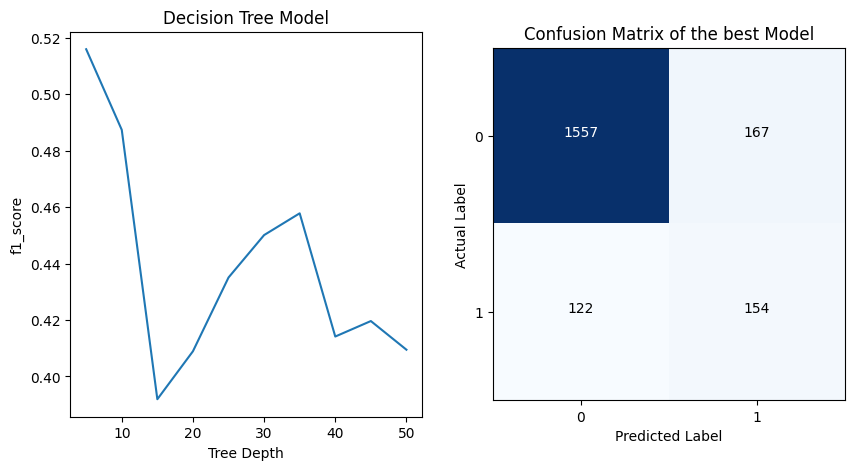

In [3]:
from sklearn import tree
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

imagesPath = 'data/data/'
trainLabelsPath = 'data/train_labels.txt'
validationLabelsPath = 'data/validation_labels.txt'

if __name__ == '__main__':
    data_loader = Data(imagesPath, trainLabelsPath, validationLabelsPath)
    train_data, train_labels, validation_data, validation_labels, test_data = data_loader.LoadData()
    train_data, validation_data, test_data = data_loader.NormalizeData(train_data, validation_data, test_data, type='standard')
    
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    
    best_f1_score = 0.0
    conf_matrix = None
    maxdepth = []
    f1_scores = []
    for i in range(5, 51, 5):
        model = tree.DecisionTreeClassifier(criterion='gini', class_weight=class_weights, max_depth=i)
        model.fit(train_data, train_labels)
        predicted_labels = model.predict(validation_data)
        score = f1_score(validation_labels, predicted_labels)
        f1_scores.append(score)
        maxdepth.append(i)
        
        if score > best_f1_score:
            conf_matrix = confusion_matrix(validation_labels, predicted_labels, labels=[0, 1])
            best_f1_score = score
    
    figure, (graph_plot, confusion_matrix_plot) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    graph_plot.plot(maxdepth, f1_scores)
    graph_plot.set_xlabel('Tree Depth')
    graph_plot.set_ylabel('f1_score')
    graph_plot.set_title('Decision Tree Model')
    
    confusion_matrix_plot.imshow(conf_matrix, cmap=plt.cm.Blues)
    confusion_matrix_plot.set_title('Confusion Matrix of the best Model')
    confusion_matrix_plot.set_xlabel('Predicted Label')
    confusion_matrix_plot.set_ylabel('Actual Label')
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    confusion_matrix_plot.set_xticks(tick_marks)
    confusion_matrix_plot.set_xticklabels(classes)
    confusion_matrix_plot.set_yticks(tick_marks)
    confusion_matrix_plot.set_yticklabels(classes)
    threshold = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        confusion_matrix_plot.text(j, i, f'{conf_matrix[i, j]:d}',
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")
    
    plt.show()
    

## 3.2 Regresie logistica
Regresiile logistice sunt folosite adesea in clasificari binare, deci ar putea reprezenta un model bun pentru detectarea anomaliilor din setul nostru de date. Ca si la modelul anterior, datele noastre de intrare vor fi reprezentate de valoarile pixelilor.

## 3.2.1 Preprocesarea datelor
Pentru preprocesarea datelor, vom folosi aceeasi clasa implementata anterior.

## 3.2.2 Testarea modelului si ajustarea hyperparametrilor
Pentru a face o predictie buna asupra datelor de testare, vom testa modelul cu mai multi parametri, iar in urma testarii vom alege cel mai bun model, caruia ii vom afisa si matricea de confuzie.
Dupa cum am observat la modelul precedent, daca folosim weight-uri pentru clase, vom obtine o performanta mai ridicata.
Pentru acest model avem 4 tipuri de solvers: liblinear, lbfgs, newton-cg si saga, insa ii vom folosi doar pe ultimii 3 in testarea noastra, deoarece cel liblinear este optim pentru seturi de date mici, cu putine caracteristici.
Pentru a folosi toate core-urile de pe sistemul nostru de calcul in antrenarea modelului, vom folosi parametrul n_jobs=-1.

Logistic Regression normalization=standard, solver=lbfgs, C=0.1, penalty=l2 got f1_score=0.2965
Logistic Regression normalization=standard, solver=lbfgs, C=1, penalty=l2 got f1_score=0.2756
Logistic Regression normalization=standard, solver=lbfgs, C=5, penalty=l2 got f1_score=0.2792
Logistic Regression normalization=standard, solver=lbfgs, C=10, penalty=l2 got f1_score=0.2741
Logistic Regression normalization=standard, solver=newton-cg, C=0.1, penalty=l2 got f1_score=0.2969
Logistic Regression normalization=standard, solver=newton-cg, C=1, penalty=l2 got f1_score=0.2876
Logistic Regression normalization=standard, solver=newton-cg, C=5, penalty=l2 got f1_score=0.2866
Logistic Regression normalization=standard, solver=newton-cg, C=10, penalty=l2 got f1_score=0.2739


c:\users\lucian\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression normalization=standard, solver=saga, C=0.1, penalty=l2 got f1_score=0.3635


c:\users\lucian\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression normalization=standard, solver=saga, C=1, penalty=l2 got f1_score=0.3635


c:\users\lucian\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression normalization=standard, solver=saga, C=5, penalty=l2 got f1_score=0.3648


c:\users\lucian\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression normalization=standard, solver=saga, C=10, penalty=l2 got f1_score=0.3629
Logistic Regression normalization=l1, solver=lbfgs, C=0.1, penalty=l2 got f1_score=0.3255
Logistic Regression normalization=l1, solver=lbfgs, C=1, penalty=l2 got f1_score=0.3263
Logistic Regression normalization=l1, solver=lbfgs, C=5, penalty=l2 got f1_score=0.3265
Logistic Regression normalization=l1, solver=lbfgs, C=10, penalty=l2 got f1_score=0.3272
Logistic Regression normalization=l1, solver=newton-cg, C=0.1, penalty=l2 got f1_score=0.3255
Logistic Regression normalization=l1, solver=newton-cg, C=1, penalty=l2 got f1_score=0.3263
Logistic Regression normalization=l1, solver=newton-cg, C=5, penalty=l2 got f1_score=0.3265
Logistic Regression normalization=l1, solver=newton-cg, C=10, penalty=l2 got f1_score=0.3272
Logistic Regression normalization=l1, solver=saga, C=0.1, penalty=l2 got f1_score=0.3275
Logistic Regression normalization=l1, solver=saga, C=1, penalty=l2 got f1_score=0.3260
Logi

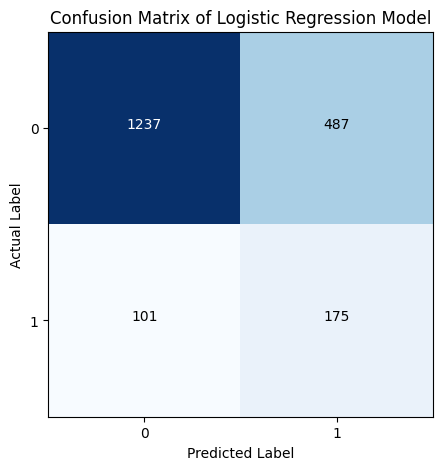

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

imagesPath = 'data/data/'
trainLabelsPath = 'data/train_labels.txt'
validationLabelsPath = 'data/validation_labels.txt'

if __name__ == '__main__':
    penalties = ['l2']
    C = [0.1, 1, 5, 10]
    solvers = ['lbfgs', 'newton-cg', 'saga']
    normalizations = ['standard', 'l1', 'l2']
    
    best_f1_score = 0.0
    conf_matrix = None
    
    data_loader = Data(imagesPath, trainLabelsPath, validationLabelsPath)
    train_data, train_labels, validation_data, validation_labels, test_data = data_loader.LoadData()
    
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    
    for normalization in normalizations:
        normalized_train_data, normalized_validation_data, normalized_test_data = data_loader.NormalizeData(train_data,
                                                                                                            validation_data,
                                                                                                            test_data,
                                                                                                            type=normalization)
        for solver in solvers:
            for c in C:
                for penalty in penalties:
                    model = LogisticRegression(penalty=penalty, solver=solver, C=c, class_weight=class_weights, n_jobs=-1)
                    model.fit(normalized_train_data, train_labels)
                    predicted_labels = model.predict(normalized_validation_data)
                    score = f1_score(validation_labels, predicted_labels)
                    if score > best_f1_score:
                        conf_matrix = confusion_matrix(validation_labels, predicted_labels, labels=[0, 1])
                        best_f1_score = score
                    print(f'Logistic Regression normalization={normalization}, solver={solver}, C={c}, penalty={penalty} got f1_score={score:.4f}')
    
                    
    plt.figure(figsize=(5, 5))
    plt.title('Confusion Matrix of Logistic Regression Model')
    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    threshold = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, f'{conf_matrix[i, j]:d}',
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")
    
    plt.show()

## 3.3 Retele neuronale convolutionale
In acest model ne vom folosi de arhitectura ResNet18, deoarece complexitatea ei este relativ mica in comparatie cu alte modele. Ne intereseaza o complexitate mai mica pentru ca nu avem un set de date foarte mare, iar, daca folosim un model prea complex, ori nu va reusi sa invete pattern-urile din imagini ori va face overfitting.
Pentru a mari totusi setul nostru de date, vom augmenta imaginile si vom crea din setul nostru de date un alt set cu mici variatii, pastrand proportia dintre clase, astfel incat modelul nostru sa invete ca anomaliile sunt mult mai rare.
Aceasta arhitectura se foloseste de conexiuni reziduale, care in acest context inseamna ca la finalul unui layer sa facem o convolutie intre input si output, aceasta convolutie fiind insumarea fiecarei pozitii din matricea de input cu pozitia corespondenta din output.

## 3.3.1 Preprocesarea datelor
Pentru a nu ne incarca memoria RAM/VRAM cu toate imaginile deodata, vom folosi un data pipeline din PyTorch, si anume DataLoader. Pentru a folosi acest pipeline, va trebui sa ne separam setul de date in fisiere separate pentru fiecare clasa.

In [ ]:
import shutil

if __name__ =='__main__':
    data = Data('data/data/', 'data/train_labels.txt', 'data/validation_labels.txt')
    train_data, train_labels, test_data, test_labels, submit_data = data.LoadData()
    i = 1
    source_path = 'data/data/'
    destination_path_anomaly = 'data/data_for_cnn/train/anomaly/'
    destination_path_normal = 'data/data_for_cnn/train/normal/'
    destination_path_test = 'data/data_for_cnn/test/test/'

    for x in train_labels:
        filename = f'{i:06}'
        if x == 0:
            shutil.copy(source_path + filename + '.png', destination_path_normal + filename + '.png')
        else:
            shutil.copy(source_path + filename + '.png', destination_path_anomaly + filename + '.png')
        i += 1

    for x in test_labels:
        filename = f'{i:06}'
        if x == 0:
            shutil.copy(source_path + filename + '.png', destination_path_normal + filename + '.png')
        else:
            shutil.copy(source_path + filename + '.png', destination_path_anomaly + filename + '.png')
        i += 1

    for i in range(17001, 22150):
        filename = f'{i:06}'
        shutil.copy(source_path + filename + '.png', destination_path_test + filename + '.png')

Dupa impartirea imaginilor in clasa corespunzatoare fiecareia, vom face augmentare si normalizare de imagini cu aceasta functie din tochvision:

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(224),
         transforms.RandomRotation(degrees=35),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

## 3.3.2 Implementarea modelului
Pentru a implementa arhitectura ResNet18 vom crea 2 clase: una pentru straturile reziduale si una pentru modelul in sine.
Topologia stratului rezidual este:
* Convolutie
* Normalizare
* Activare ReLU
* Convolutie
* Normalizare
* Convolutie Skip-Connection
* Activare ReLU
Parametrul de downsample va fi folosit pentru a redimensiona matricea din input, daca este necesar, pentru a face Convolutia de Skip-Connection.

Convolutiile din acest strat vor avea kernel-ul de 3x3 iar stride-ul ori de 1 ori de 2, in functie de stratul pe care suntem.

In [2]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None) -> None:
        super(ResNetBlock, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(out_channels)
        self.Conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(out_channels)
        self.ReLU_activation = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identityTensor = x.clone()
        x = self.Conv1(x)
        x = self.BatchNorm1(x)
        x = self.ReLU_activation(x)
        x = self.Conv2(x)
        x = self.BatchNorm2(x)
        if self.downsample is not None:
            identityTensor = self.downsample(identityTensor)
        x += identityTensor
        x = self.ReLU_activation(x)
        return x

In toate arhitecturile ResNet vom avea la inceput o convolutie cu un kernel de 7x7 si cu stride de 2, urmata mai apoi de un strat MaxPool de 3x3 tot cu stride de 2. Mai apoi, specific pentru arhitectura ResNet18, vom avea 8 straturi reziduale, cate doua din fiecare cu 64, 128, 256, 512 filtre. Primul strat are stride de 1, restul vor avea stride-ul setat la 2 pentru a doua convolutie din stratul rezidual.
La finalul modelului vom crea un strat propriu de clasificare, intrucat ResNet18 este folosit in clasificarea a 1000 de clase de imagini, iar problema noastra implica o predictie binara. Asadar, clasificarea o vom face cu ajutorul unui strat liniar, obtinut prin liniarizarea output-ului de la ultimul strat, urmat de un strat liniar cu 2 noduri si mai apoi un ultim strat cu un singur nod cu activare de tip sigmoid.

In [3]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self) -> None:
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.Conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(self.in_channels)
        self.ReLU_activation = nn.ReLU(inplace=True)
        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.Layer1 = self.makeResNetLayer(64)
        self.Layer2 = self.makeResNetLayer(128, stride=2)
        self.Layer3 = self.makeResNetLayer(256, stride=2)
        self.Layer4 = self.makeResNetLayer(512, stride=2)

        self.AvgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.Classifier = nn.Sequential(
            nn.Linear(512, 2),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def makeResNetLayer(self, out_channels, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        layers.append(ResNetBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.Conv1(x)
        x = self.BatchNorm1(x)
        x = self.ReLU_activation(x)
        x = self.MaxPool(x)

        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)

        x = self.AvgPool(x)
        x = torch.flatten(x, 1)
        x = self.Classifier(x)
        return x

## 3.3.3 Testarea modelului si tunarea hyperparametrilor
In acest pas ne vom folosi de accelerarea data de GPU.
Pentru a obtine o performanta mai buna, vom folosi un scheduler, mai exact ReduceLROnPlateau din libraria Torch pentru a scadea rata de invatare in momentul in care observam ca loss-ul stagneaza. Vom reduce rata de invatare cu un factor 0.1. De asemenea, vom salva in timpul antrenarii parametrii modelului cand a obtinut cel mai bun f1_score la validare, astfel avem si flexibilitatea de a opri programul in cazul in care observam ca modelul nu se mai imbunatateste, sau face overfitting si pastram astfel parametrii cei mai optimi.

Din teste anterioare am observat ca optimizatorul SGD da rezultate mult mai bune decat cel Adam, asa ca vom folosi doar SGD.

 Progress Training: epoch: 1/25 batch: 234/234 accuracy: 0.8485 f1_score: 0.3251 loss_value: 0.9164 learning rate: 0.010000
 Progress Testing: epoch: 1/25 batch: 32/32 accuracy: 0.7990 f1_score: 0.4176
 Progress Training: epoch: 2/25 batch: 234/234 accuracy: 0.8582 f1_score: 0.5123 loss_value: 0.8845 learning rate: 0.010000
 Progress Testing: epoch: 2/25 batch: 32/32 accuracy: 0.8686 f1_score: 0.4981
 Progress Training: epoch: 3/25 batch: 234/234 accuracy: 0.8624 f1_score: 0.5545 loss_value: 0.8737 learning rate: 0.010000
 Progress Testing: epoch: 3/25 batch: 32/32 accuracy: 0.8382 f1_score: 0.5404
 Progress Training: epoch: 4/25 batch: 234/234 accuracy: 0.8704 f1_score: 0.5845 loss_value: 0.8649 learning rate: 0.010000
 Progress Testing: epoch: 4/25 batch: 32/32 accuracy: 0.8779 f1_score: 0.6016
 Progress Training: epoch: 5/25 batch: 234/234 accuracy: 0.8773 f1_score: 0.6005 loss_value: 0.8598 learning rate: 0.010000
 Progress Testing: epoch: 5/25 batch: 32/32 accuracy: 0.8809 f1_scor

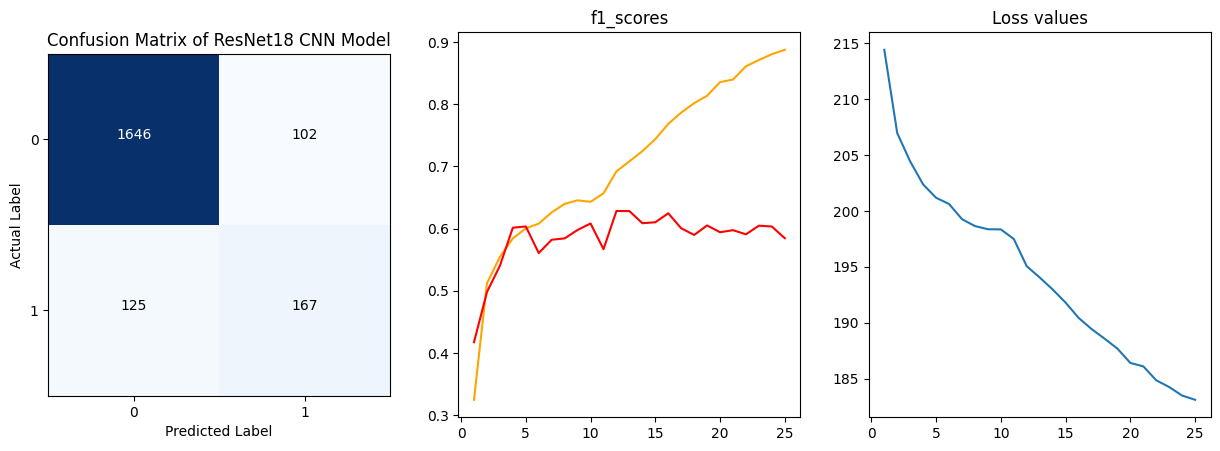

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

data_dir = 'data/data_for_cnn/train_data'
predict_dir = 'data/data_for_cnn/test_data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 25
NAME = 'ResNet18-Architecture-' + str(epochs) + '-'+ datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.RandomCrop(224),
         transforms.RandomRotation(degrees=35),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    transformPredict = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transformPredict)
    train_size = int(0.88 * len(dataset))   #proportia aproximativa intre datele de antrenare si cele de validare
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])   #despartim setul de date conform proportiei de mai sus
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
    predict_dataset = datasets.ImageFolder(root=predict_dir, transform=transformPredict)
    data_to_predict = torch.utils.data.DataLoader(predict_dataset, batch_size=64, shuffle=False)
    model = ResNet18().to(device)
    best_f1_score = 0.0
    class_weights = torch.tensor([3.38]).to(device)    # folosim weight-ul obtinut anterior si il hard-codam pentru a face procesul mai rapid
    loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
    
    train_loss_values = []
    train_f1_scores = []
    validation_f1_scores = []
    
    for epoch in range(1, epochs + 1):
        outputs = None
        labels = None
        total = 0
        correct = 0
        tp = 0
        fp = 0
        fn = 0
        avg_loss = 0.0
        f1_score_running = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            outputs = model(inputs)
            mask = outputs >= 0.5
            new_outputs = torch.zeros_like(outputs)
            new_outputs[mask] = 1.0
            total += labels.size(0)
            correct += (new_outputs == labels).sum().item()
            tp += ((new_outputs == 1) & (labels == 1)).sum().item()
            fp += ((new_outputs == 1) & (labels == 0)).sum().item()
            fn += ((new_outputs == 0) & (labels == 1)).sum().item()
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            try:
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
                f1_score_running = 2 * (precision * recall) / (precision + recall)
            except ZeroDivisionError:
                f1_score_running = 0
            avg_loss += loss.item()
            print(f' Progress Training: epoch: {epoch}/{epochs} batch: {i + 1}/{len(train_loader)} accuracy: {(correct/total):.4f} f1_score: {(f1_score_running):.4f} loss_value: {(avg_loss/(i+1)):.4f} learning rate: {optimizer.param_groups[0]["lr"]:.6f}', end='\r')
        scheduler.step(loss)
        print()
        correct = 0
        total = 0
        train_f1_scores.append(f1_score_running)
        train_loss_values.append(avg_loss)
        with torch.no_grad():
            outputs = None
            labels = None
            tp = 0
            fp = 0
            fn = 0
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                labels = labels.float()
                outputs = model(inputs)
                mask = outputs >= 0.5
                new_outputs = torch.zeros_like(outputs)
                new_outputs[mask] = 1.0
                tp += ((new_outputs == 1) & (labels == 1)).sum().item()
                fp += ((new_outputs == 1) & (labels == 0)).sum().item()
                fn += ((new_outputs == 0) & (labels == 1)).sum().item()
                total += labels.size(0)
                correct += (new_outputs == labels).sum().item()
                try:
                    precision = tp / (tp + fp)
                    recall = tp / (tp + fn)
                    f1_score_running = 2 * (precision * recall) / (precision + recall)
                    if f1_score_running > best_f1_score:
                        best_f1_score = f1_score_running
                        torch.save(model.state_dict(), 'Models/ModelParameters/' + NAME + '.pt')
                except ZeroDivisionError:
                    f1_score_running = 0
                print(f' Progress Testing: epoch: {epoch}/{epochs} batch: {i + 1}/{len(test_loader)} accuracy: {(correct/total):.4f} f1_score: {(f1_score_running):.4f}', end='\r')
            print()
        validation_f1_scores.append(f1_score_running)
        
            
    model.load_state_dict(torch.load('Models/ModelParameters/' + NAME + '.pt'))
        
    with torch.no_grad():
        actual_labels = []
        predicted_labels = []
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            outputs = model(inputs)
            mask = outputs >= 0.5
            new_outputs = torch.zeros_like(outputs)
            new_outputs[mask] = 1.0
            actual_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(new_outputs.cpu().numpy().astype(int))
            print(f' Progress Testing: batch: {i + 1}/{len(test_loader)}', end='\r')
    print()
    
    plt.show()
    
    steps = [i for i in range(1, epochs + 1)]
    
    figure, (confusion_matrix_plot, f1_score_plot, loss_plot) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    conf_matrix = confusion_matrix(actual_labels, predicted_labels)
    confusion_matrix_plot.imshow(conf_matrix, cmap=plt.cm.Blues)
    confusion_matrix_plot.set_title('Confusion Matrix of ResNet18 CNN Model')
    confusion_matrix_plot.set_xlabel('Predicted Label')
    confusion_matrix_plot.set_ylabel('Actual Label')
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    confusion_matrix_plot.set_xticks(tick_marks)
    confusion_matrix_plot.set_xticklabels(classes)
    confusion_matrix_plot.set_yticks(tick_marks)
    confusion_matrix_plot.set_yticklabels(classes)
    threshold = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        confusion_matrix_plot.text(j, i, f'{conf_matrix[i, j]:d}',
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")
    
    f1_score_plot.plot(steps, train_f1_scores, color='orange', label='Train f1_score')
    f1_score_plot.plot(steps, validation_f1_scores, color='red', label='Validation f1_score')
    f1_score_plot.set_title('f1_scores')
    
    loss_plot.plot(steps, train_loss_values)
    loss_plot.set_title('Loss values')
    
    plt.show()

Din cate putem observa, 25 de epoci este suficient, in cazul nostru, pentru a obtine un model antrenat, intrucat dupa 10-15 epoci modelul incepe deja sa memoreze imaginile de antrenare si sa se opreasca din a distinge pattern-uri generale pentru a clasifica imaginile in clasa lor.

## 4 Solutia finala

Din modelele antrenate anterior putem observa ca cel mai bun scor pe datele de validare il obtin retelele neuronale convolutionale, dupa arhitectura ResNet18.

Astfel, vom face predictiile asupra datelor de testare folosind algoritmul descris mai sus.

Rezultatele le vom afisa cu ajutorul acestei functii, implementata mai sus in clasa Data:

In [ ]:
    def PrintData(self, predicted_values):
        for x in predicted_values:
            outFile.write(f'{self.predicted_image_index:06d},{int(x)}\n')
            self.predicted_image_index += 1

In solutia finala, vom incarca parametrii modelului pentru care s-a obtinut cel mai bun f1_score si vom genera predictiile pentru datele de testare cu ajutorul acestui cod:

In [ ]:
data_loader = Data()
data_loader.OpenFolder()
with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_to_predict):
            inputs = inputs.to(device)
            outputs = model(inputs)
            mask = outputs >= 0.5
            new_outputs = torch.zeros_like(outputs)
            new_outputs[mask] = 1
            new_outputs[~mask] = 0
            print_predictions(new_outputs)
            print(f' Progress Predicting: batch: {i}/{len(data_to_predict)}', end='\r')
    print()
    outFile.close()
data_loader.CloseFolder()